# Generalized Integrate-and-fire model

References:

- Mihalaş, Ştefan, and Ernst Niebur. "A generalized linear integrate-and-fire neural model produces diverse spiking behaviors." Neural computation 21.3 (2009): 704-718.

Generalized integrate-and-fire model is a spiking neuron model, describes single neuron behavior and can generate most kinds of firing patterns by tuning parameters.

Generalized IF model is originated from Leaky Integrate-and-Fire model (LIF model), yet it's differentiated from LIF model, for it includes internal currents $I_j$ in its expressions.

$$\frac{d I_j}{d t} = -k_j I_j$$

$$\tau\frac{d V}{d t} = - (V - V_{rest}) + R\sum_{j}I_j + RI$$

$$\frac{d V_{th}}{d t} = a(V - V_{rest}) - b(V_{th} - V_{th\infty})$$


Generalized IF neuron fire when $V$ meet $V_{th}$:

$$I_j \leftarrow R_j I_j + A_j$$

$$V \leftarrow V_{reset}$$

$$V_{th} \leftarrow max(V_{th_{reset}}, V_{th}) $$

In [1]:
import matplotlib.pyplot as plt
import brainpy as bp
import brainmodels
print(brainmodels.__version__)

1.0.0


These arbitrary number of internal currents $I_j$ can be seen as currents caused by ion channels' dynamics, provides the GeneralizedIF model a flexibility to generate various firing patterns.

With appropriate parameters, we can reproduce most of the single neuron firing patterns. In the original paper (Mihalaş et al., 2009), the author used two internal currents $I1$ and $I2$.

In [2]:
# set parameters
num2mode = ["tonic_spiking",       "class_1",                           "spike_frequency_adaptation",
            "phasic_spiking",      "accomodation",                      "threshold_variability",
            "rebound_spike",       "class_2",                           "integrator",
            "input_bistability",   "hyperpolarization_induced_spiking", "hyperpolarization_induced_bursting",
            "tonic_bursting",      "phasic_bursting",                   "rebound_burst",
            "mixed_mode",          "afterpotentials",                   "basal_bistability",
            "preferred_frequency", "spike_latency"]

mode2param = {
    "tonic_spiking": {
        "input": [(1.5, 200.)]
    },
    "class_1": {
        "input": [(1. + 1e-6, 500.)]
    },
    "spike_frequency_adaptation": {
        "a": 0.005, "input": [(2., 200.)]
    },
    "phasic_spiking": {
        "a": 0.005, "input": [(1.5, 500.)]
    },
    "accomodation": {
        "a": 0.005,
        "input": [(1.5, 100.), (0, 500.), (0.5, 100.),
                  (1., 100.), (1.5, 100.), (0., 100.)]
    },
    "threshold_variability": {
        "a": 0.005,
        "input": [(1.5, 20.), (0., 180.), (-1.5, 20.),
                  (0., 20.), (1.5, 20.), (0., 140.)]
    },
    "rebound_spike": {
        "a": 0.005,
        "input": [(0, 50.), (-3.5, 750.), (0., 200.)]
    },
    "class_2": {
        "a": 0.005,
        "input": [(2 * (1. + 1e-6), 200.)],
        "V_th": -30.
    },
    "integrator": {
        "a": 0.005,
        "input": [(1.5, 20.), (0., 10.), (1.5, 20.), (0., 250.),
                  (1.5, 20.), (0., 30.), (1.5, 20.), (0., 30.)]
    },
    "input_bistability": {
        "a": 0.005,
        "input": [(1.5, 100.), (1.7, 400.),
                  (1.5, 100.), (1.7, 400.)]
    },
    "hyperpolarization_induced_spiking": {
        "V_th_reset": -60.,
        "V_th_inf": -120.,
        "input": [(-1., 400.)],
        "V_th": -50.
    },
    "hyperpolarization_induced_bursting": {
        "V_th_reset": -60.,
        "V_th_inf": -120.,
        "A1": 10.,
        "A2": -0.6,
        "input": [(-1., 400.)],
        "V_th": -50.
    },
    "tonic_bursting": {
        "a": 0.005,
        "A1": 10.,
        "A2": -0.6,
        "input": [(2., 500.)]
    },
    "phasic_bursting": {
        "a": 0.005,
        "A1": 10.,
        "A2": -0.6,
        "input": [(1.5, 500.)]
    },
    "rebound_burst": {
        "a": 0.005,
        "A1": 10.,
        "A2": -0.6,
        "input": [(0, 100.), (-3.5, 500.), (0., 400.)]
    },
    "mixed_mode": {
        "a": 0.005,
        "A1": 5.,
        "A2": -0.3,
        "input": [(2., 500.)]
    },
    "afterpotentials": {
        "a": 0.005,
        "A1": 5.,
        "A2": -0.3,
        "input": [(2., 15.), (0, 185.)]
    },
    "basal_bistability": {
        "A1": 8.,
        "A2": -0.1,
        "input": [(5., 10.), (0., 90.), (5., 10.), (0., 90.)]
    },
    "preferred_frequency": {
        "a": 0.005,
        "A1": -3.,
        "A2": 0.5,
        "input": [(5., 10.), (0., 10.), (4., 10.), (0., 370.),
                  (5., 10.), (0., 90.), (4., 10.), (0., 290.)]
    },
    "spike_latency": {
        "a": -0.08,
        "input": [(8., 2.), (0, 48.)]
    }
}

Define running function to simulate Generalized IF neuron group. Users may specify the spiking pattern they want with the input parameter `mode`.

In [3]:
def run_GIF_with_mode(mode = 'tonic_spiking', size = 10.,
                      row_p = 0, col_p = 0, fig = None, gs = None):
    
    print(f"Running GIF neuron neu with mode '{mode}'")
    neu = brainmodels.neurons.GeneralizedIF(size, monitors = ['V', 'V_th', 'input'])
    param = mode2param[mode].items()
    member_type = 0
    for (k, v) in param:
        if k == 'input':
            I_ext, dur = bp.inputs.constant_current(v)
            member_type += 1
        else:
            if member_type==0:
                exec("neu.%s = %f"%(k, v))
            else:
                exec("neu.%s = bp.backend.ones(size) * %f"%(k, v))
    neu.run(dur, inputs = ('input', I_ext), report = False)

    ts = neu.mon.ts
    ax1 = fig.add_subplot(gs[row_p, col_p])
    ax1.title.set_text(f'{mode}')

    ax1.plot(ts, neu.mon.V[:, 0], label='V')
    ax1.plot(ts, neu.mon.V_th[:, 0], label='V_th')
    ax1.set_xlabel('Time (ms)')
    ax1.set_ylabel('Membrane potential')
    ax1.set_xlim(-0.1, ts[-1] + 0.1)
    plt.legend()

    ax2 = ax1.twinx()
    ax2.plot(ts, I_ext, color = 'turquoise', label='input')
    ax2.set_xlabel('Time (ms)')
    ax2.set_ylabel('External input')
    ax2.set_xlim(-0.1, ts[-1] + 0.1)
    ax2.set_ylim(-5., 20.)
    plt.legend(loc = 'lower left')

Simulate Generalized IF neuron groups to generate different spiking patterns. Here we plot 20 spiking patterns in groups of 4. The plots are labeled with corresponding pattern names above the plots.

Running GIF neuron neu with mode 'tonic_spiking'
Running GIF neuron neu with mode 'class_1'
Running GIF neuron neu with mode 'spike_frequency_adaptation'
Running GIF neuron neu with mode 'phasic_spiking'


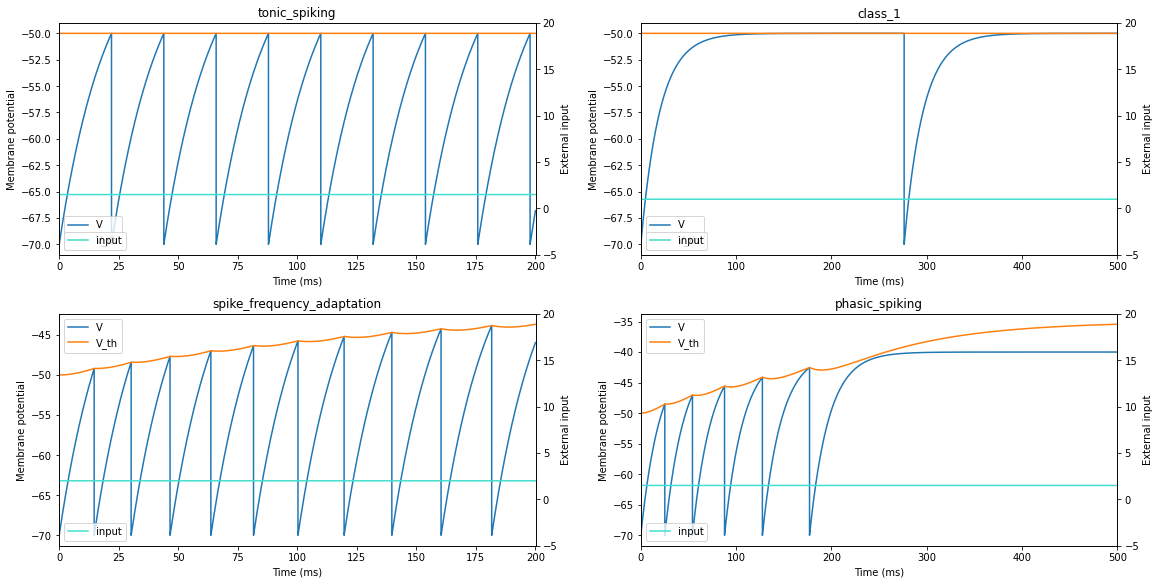

Running GIF neuron neu with mode 'accomodation'
Running GIF neuron neu with mode 'threshold_variability'
Running GIF neuron neu with mode 'rebound_spike'
Running GIF neuron neu with mode 'class_2'


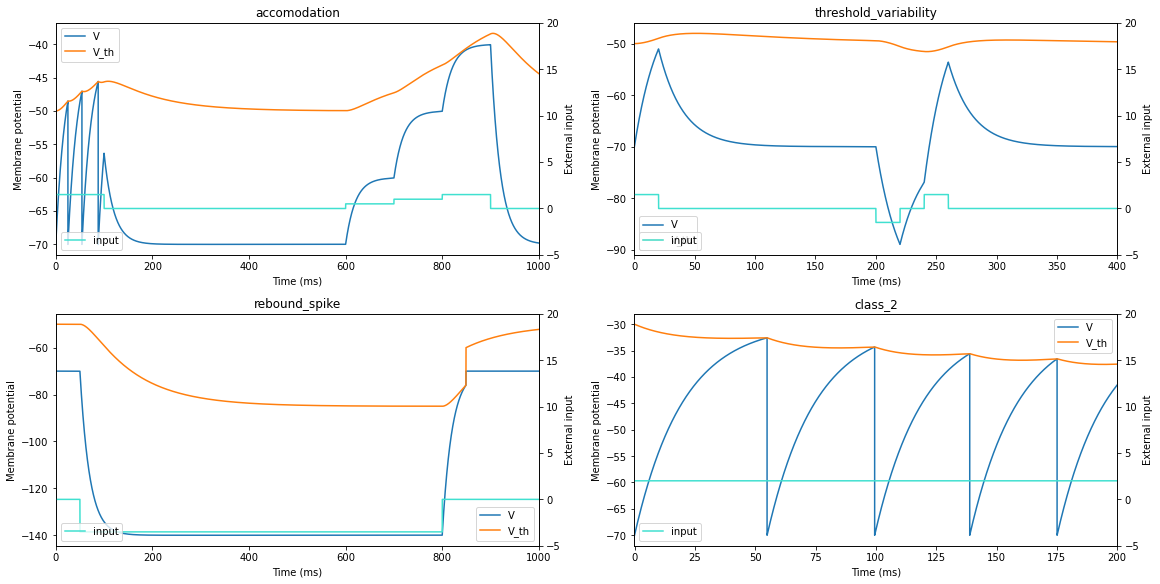

Running GIF neuron neu with mode 'integrator'
Running GIF neuron neu with mode 'input_bistability'
Running GIF neuron neu with mode 'hyperpolarization_induced_spiking'
Running GIF neuron neu with mode 'hyperpolarization_induced_bursting'


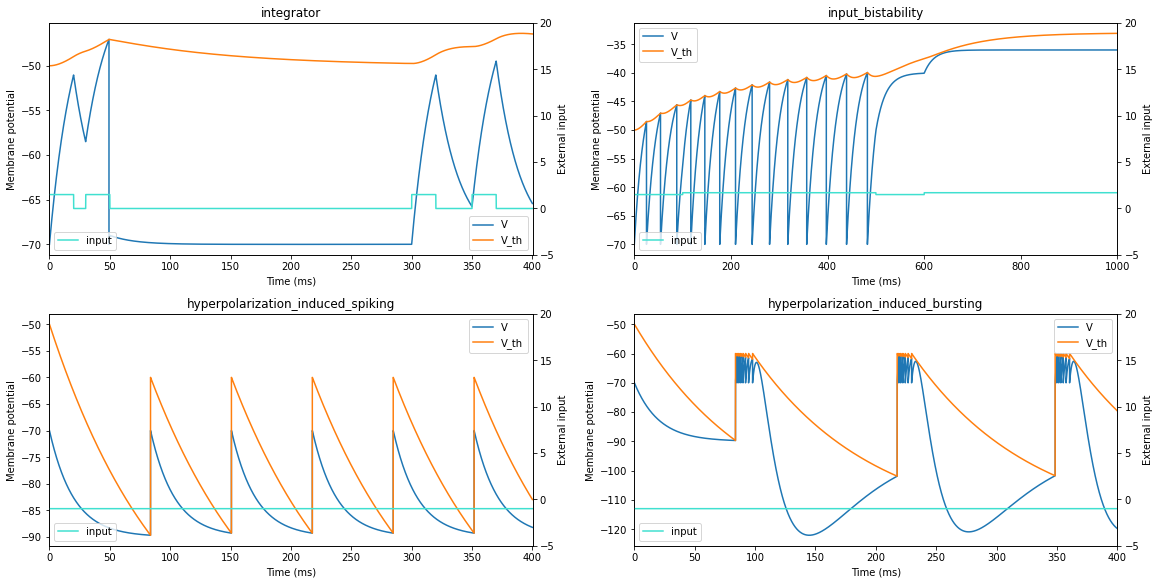

Running GIF neuron neu with mode 'tonic_bursting'
Running GIF neuron neu with mode 'phasic_bursting'
Running GIF neuron neu with mode 'rebound_burst'
Running GIF neuron neu with mode 'mixed_mode'


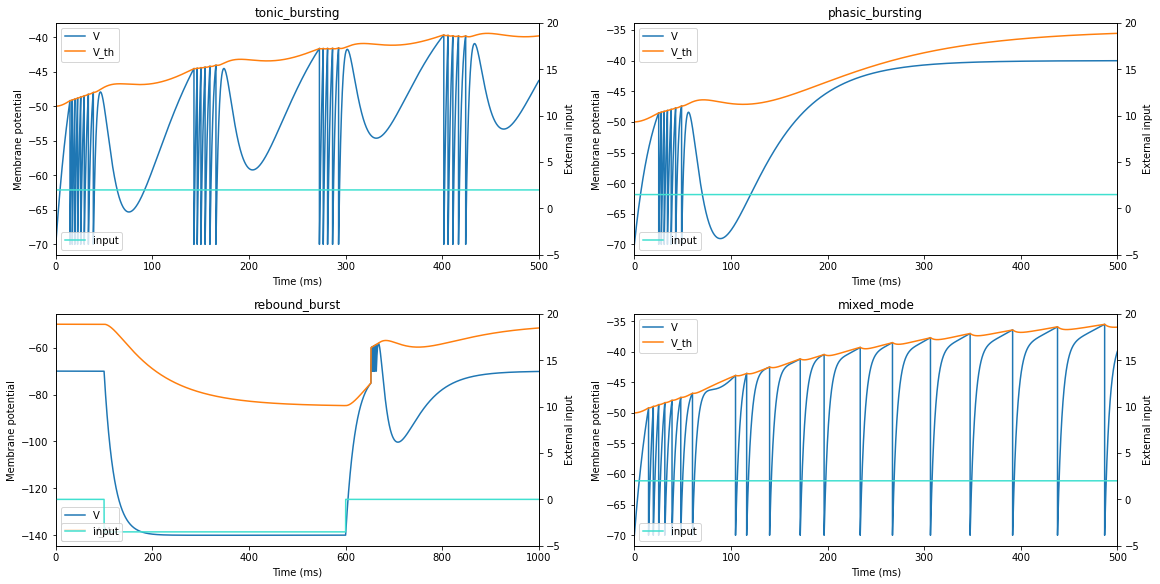

Running GIF neuron neu with mode 'afterpotentials'
Running GIF neuron neu with mode 'basal_bistability'
Running GIF neuron neu with mode 'preferred_frequency'
Running GIF neuron neu with mode 'spike_latency'


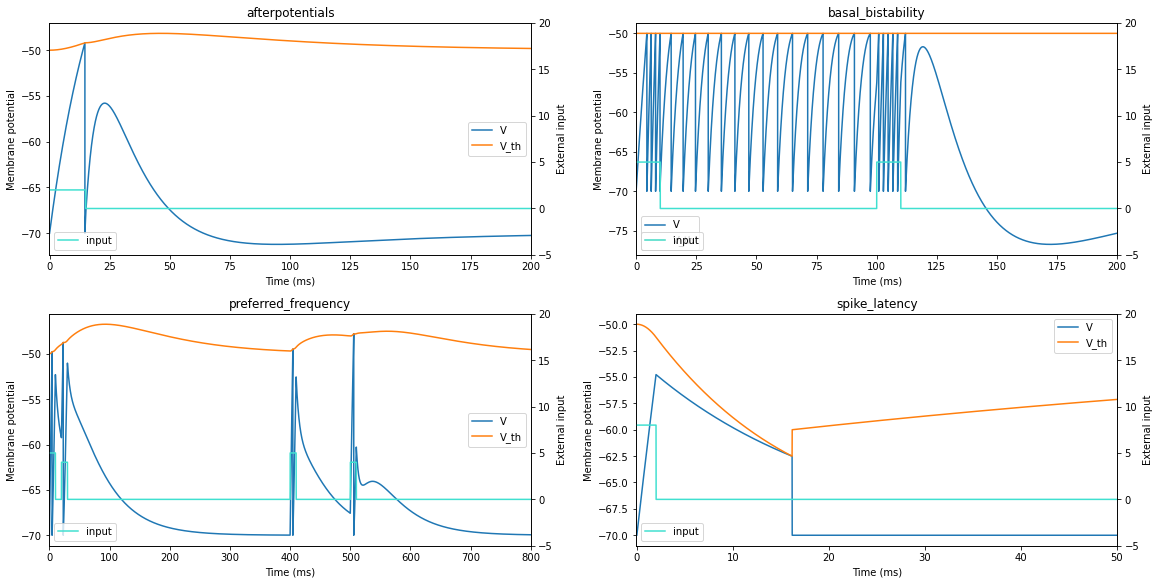

In [4]:
size = 10
pattern_num = 20
row_b = 2
col_b = 2
size_b = row_b * col_b
for i in range(pattern_num):
    if i % size_b == 0:
        fig, gs = bp.visualize.get_figure(row_b, col_b, 4, 8)
    mode = num2mode[i]
    run_GIF_with_mode(mode = mode, size = size,
                      row_p = i % size_b // col_b,
                      col_p = i % size_b % col_b,
                      fig = fig, gs = gs)
    if (i+1) % size_b == 0:
        plt.show()